RFM 기법을 이용해서 고객을 군집화
<ul>
    <li>RECENCY(R): 가장 최근 상품 구입 일에서 오늘까지의 시간</li>
    <li>FREQUENCY(F): 상품 구매 횟수</li>
    <li>MONETARY(M): 총 구매 금액</li>
</ul>


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
retail_df = pd.read_csv('./data/Online_Retail.csv', encoding='latin1')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
retail_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceDate Datetime으로 형변환

In [45]:
date_format = "%m/%d/%y %H:%M"

In [47]:
retail_df['InvoiceDate'] = retail_df['InvoiceDate'].apply(lambda x : datetime.datetime.strptime(x, date_format))

1. Null 데이터 제거: 고객 식별 변호가 없는 데이터 삭제
2. 오류 데이터 삭제: Quantity 또는 UnitPrice가 0보다 작은 경우
3. CustomerID -> int형으로 형변환

In [5]:
retail_df = retail_df[(retail_df['Quantity']>0) & (retail_df['UnitPrice']>0) & (retail_df['CustomerID'].notnull())]

In [7]:
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [8]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  int64  
 7   Country      397884 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 27.3+ MB


### RFM 기반 데이터 가공

주문 금액 = UnitPrice * Quantity

In [9]:
retail_df['OrderAmount'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [48]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [20]:
# 주문 수 상위 5명
retail_df['CustomerID'].value_counts().head(5)

CustomerID
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: count, dtype: int64

In [18]:
# 금액 순 상위 5명
retail_df.groupby('CustomerID')['OrderAmount'].sum().sort_values(ascending=False).head(5)

CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: OrderAmount, dtype: float64

고객 레벨로 세그멘테이션을 수행해야하기 떄문에 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 groupby

In [61]:
cust_df = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'OrderAmount': 'sum'
})

In [62]:
cust_df = cust_df.reset_index()

In [63]:
cust_df = cust_df.rename(columns ={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'OrderAmount':'Monetary'
})

In [64]:
cust_df

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24
3,12349,2011-11-21 09:51:00,73,1757.55
4,12350,2011-02-02 16:01:00,17,334.40
...,...,...,...,...
4333,18280,2011-03-07 09:52:00,10,180.60
4334,18281,2011-06-12 10:53:00,7,80.82
4335,18282,2011-12-02 11:43:00,12,178.05
4336,18283,2011-12-06 12:02:00,756,2094.88


In [65]:
# Recency 컬럼 값을 (오늘 날짜 - 최근 주문 날짜)로 변경

In [66]:
today = datetime.datetime.now()

In [67]:
recent_day = cust_df['Recency'].max()
recent_day

Timestamp('2011-12-09 12:50:00')

In [68]:
cust_df['Recency'] = today - cust_df['Recency']

In [69]:
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)

In [70]:
cust_df

,CustomerID,Recency,Frequency,Monetary
0,12346,4791,1,77183.60
1,12347,4468,182,4310.00
2,12348,4541,31,1797.24
3,12349,4484,73,1757.55
4,12350,4776,17,334.40
...,...,...,...,...
4333,18280,4743,10,180.60
4334,18281,4646,7,80.82
4335,18282,4473,12,178.05
4336,18283,4469,756,2094.88


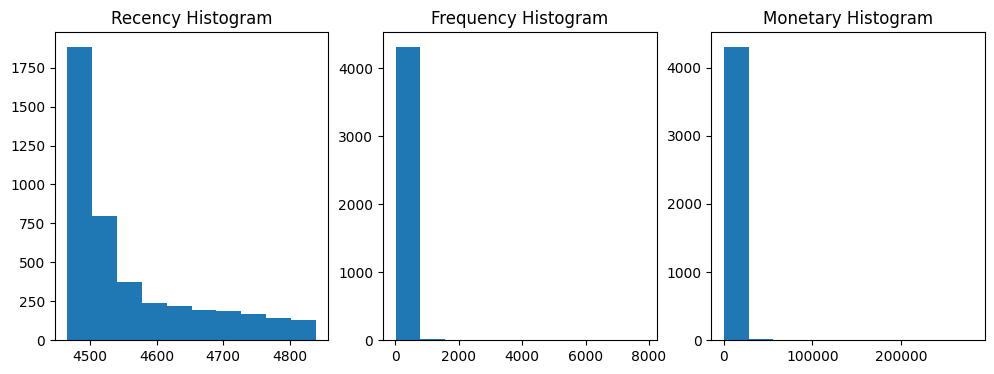

In [71]:
#hist()를 이용하여 각 칼럼의 값 분포도 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

In [72]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,4557.975795,91.720609,2054.266460
std,100.018076,228.785094,8989.230441
min,4466.000000,1.000000,3.750000
25%,4483.000000,17.000000,307.415000
50%,4516.000000,41.000000,674.485000
75%,4607.750000,100.000000,1661.740000
max,4839.000000,7847.000000,280206.020000


<ul>
    <li>Recency는 평균이 92.7이지만, 50%인 51보다 크게 높음, max 는 374로 75%인 143보다 훨씬 커 왜곡 정도가 심함</li>
    <li>Frequency의 경우 평균이 90.3이지만 max 값 7847를 포함한 상위의 몇 개의 큰 값으로 인해 75%가 99.25에 가까움</li>
    <li>Monetary도 마찬가지로 상위의 큰 값으로 인해 평균은 1864.3으로 75%인 1576.5보다 높은 값이 확인 됨</li>
</ul>
->
StandardScaler로 평균과 표준편차를 재조정

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [76]:
X_features = cust_df[['Recency','Frequency', 'Monetary']]

In [77]:
X_features

,Recency,Frequency,Monetary
0,4791,1,77183.60
1,4468,182,4310.00
2,4541,31,1797.24
3,4484,73,1757.55
4,4776,17,334.40
...,...,...,...
4333,4743,10,180.60
4334,4646,7,80.82
4335,4473,12,178.05
4336,4469,756,2094.88
